In [1]:
# load basic packages
%matplotlib inline


import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

matplotlib.rcParams['figure.figsize'] = (10,10)

In [2]:
# load data
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

1460 training data points,
79 features(both categorical and numerical),
missing data

# visualization

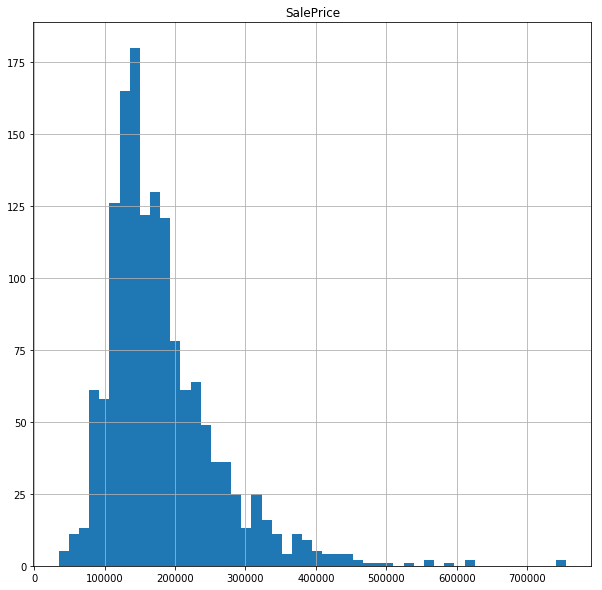

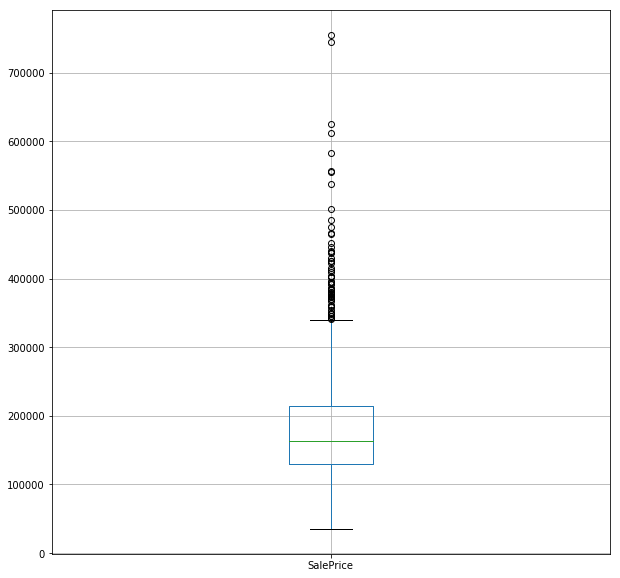

In [3]:
# explore target
explore = data.copy()
explore.hist(column = 'SalePrice',bins = 50)
plt.figure()
explore.boxplot(column = 'SalePrice')

based on histogram, it is obvious that the target value has a heavy tail
but , here in this problem, instead of price itself the target value is logarithm of price, and the objective is to minimiza the root mean square error(RMSE) between LOGARITHM of real price and LOGARITHM of predicted price.
by using logarithm, instead of focusing on difference( y - y_hat) the focuse is on the ration (log(y) - log(y_hat)) = log(y/y_hat) and in this way the prediction of cheap housese is important as prediction of expensive ones.
another point is that the (y - y_hat)^2 is even, so the penalty for overpricing and underpricing is the same but (log(y/y_hat))^2 is not generally symmetric but around 1 it is. (deriviteve(log(x) =1/x)

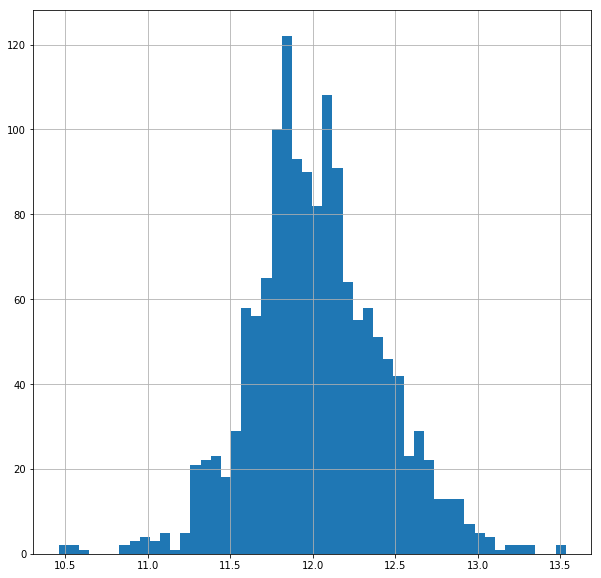

In [4]:
# histogram of a logarithm of target
y_log = np.log1p(explore['SalePrice'])
y_log.hist(bins = 50)

in the next step, let's plot the corrolation between numerical attributes and target in heatmap syle

In [5]:
def corrolation_heatmap(data):
    ''' plot corrolation between numerical data in a heatmap style'''
    corr_matrix = data.corr()
    fig, ax = plt.subplots()
    cax = ax.imshow(corr_matrix.values, interpolation= 'nearest', cmap = 'bwr')
    ax.set_yticks(np.arange(len(list(corr_matrix)))+.5)
    ax.set_xticks(np.arange(len(list(corr_matrix)))+.5)
    ax.set_yticklabels(list(corr_matrix), rotation=0,fontsize=8,
    verticalalignment = 'bottom')
    ax.set_xticklabels(list(corr_matrix), rotation=90,fontsize=8,
    horizontalalignment= 'right')
    fig.colorbar(cax)

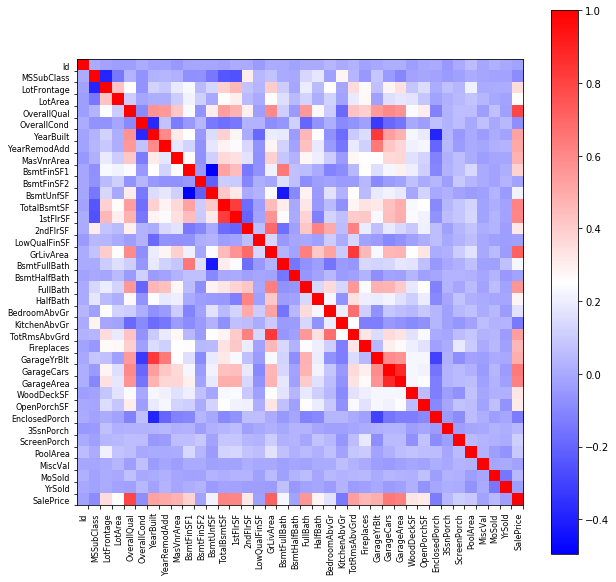

In [6]:
corrolation_heatmap(explore)

base on above figure, sale price is strongly linearly dependant of OverallQual, GrLiveArea, GarageCars(or GarageArea). inaddition some of attributes are (linearly) corolated to each other.                                                 
saleprice slightly corrolated negatively to some attributes

lets plot these corrolated features versus target to examine them deeply

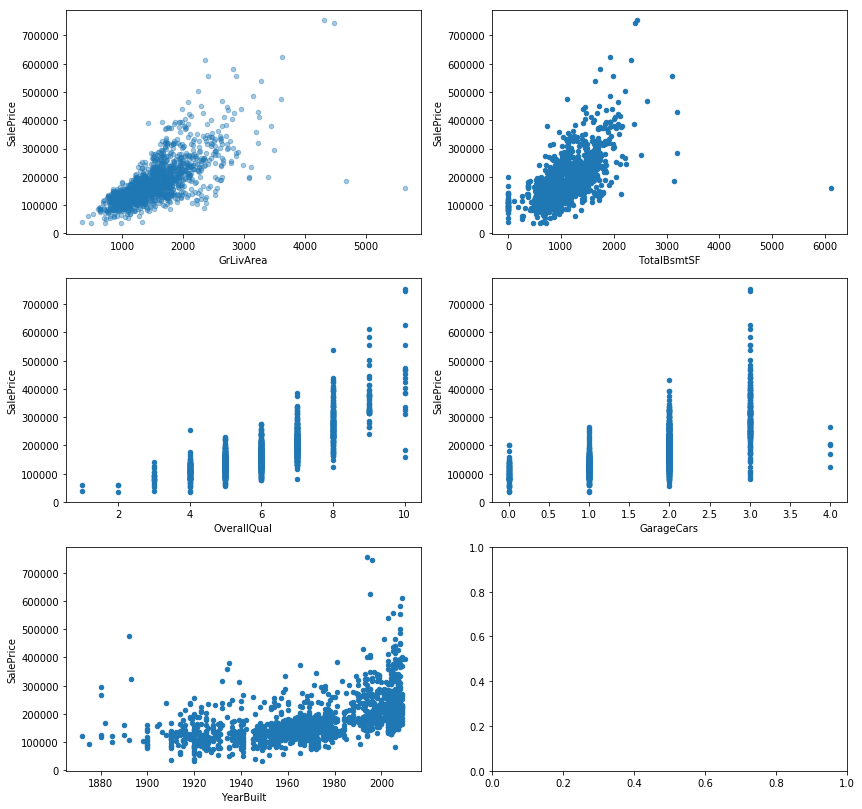

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 14))
explore.plot.scatter(x = 'GrLivArea', y = 'SalePrice', alpha = .4, ax=axes[0,0])
explore.plot.scatter(x = 'TotalBsmtSF', y = 'SalePrice', ax=axes[0,1])
explore.plot.scatter(x = 'OverallQual', y = 'SalePrice', ax=axes[1,0])
explore.plot.scatter(x = 'GarageCars', y = 'SalePrice', ax=axes[1,1])
explore.plot.scatter(x = 'YearBuilt', y = 'SalePrice', ax=axes[2,0])


so there is a linear corrolation between target and GrLiveArea. however, there are two houses with large ground living area that are sold so cheap. ( probably outliers)                                                                      about OverallQuall, there has a linear(almost exponentail) relationship with target ( problaly defining new attribute based on that)            
about number of cars and basement squarefeet, almost as the feature increase the house becomes more expensive but from some point, this increasement does not have a positive influence on price.

Let's explore some of the categorical features

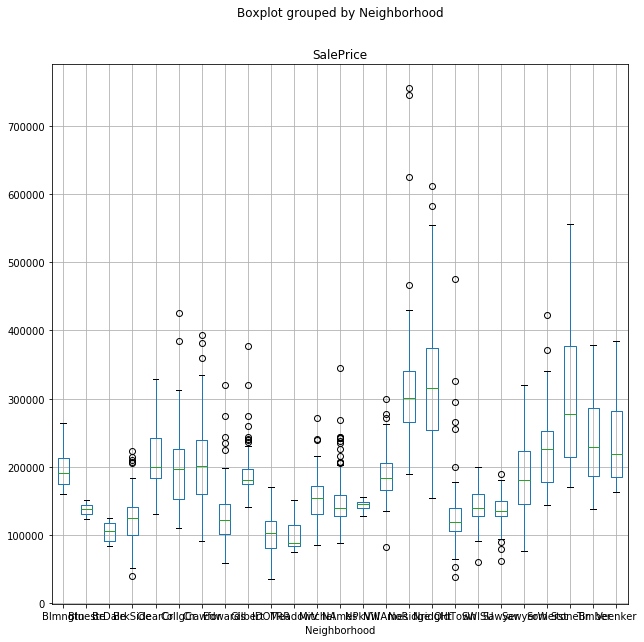

In [8]:
explore.boxplot(column = 'SalePrice', by = 'Neighborhood')
# it is obviouse some neighberhoods are more expensive

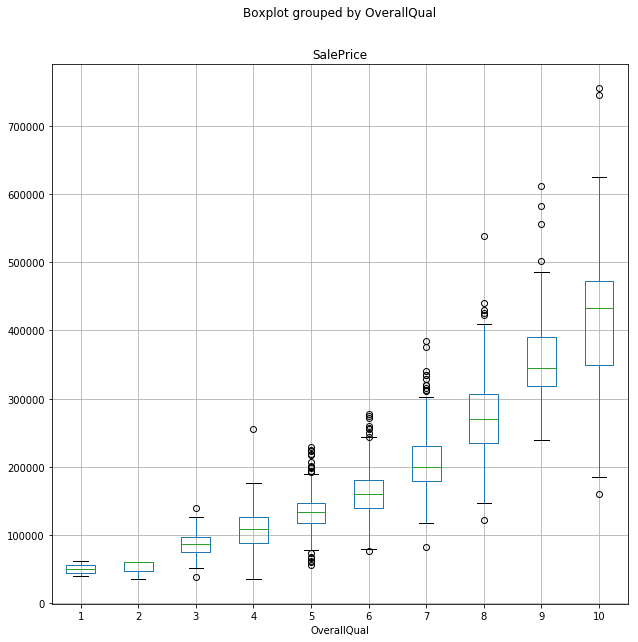

In [9]:
explore.boxplot(column = 'SalePrice', by = 'OverallQual')

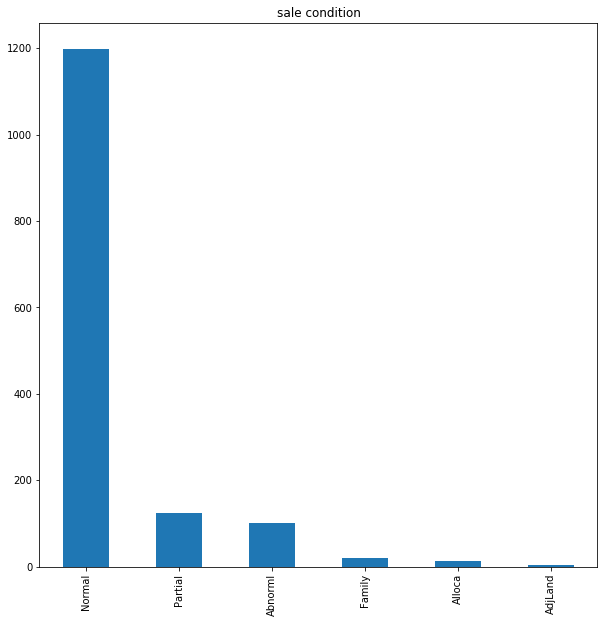

In [10]:
explore['SaleCondition'].value_counts().plot.bar()
plt.title('sale condition')
# to see how is sell condition in the whole data sat

<class 'pandas.core.frame.DataFrame'>


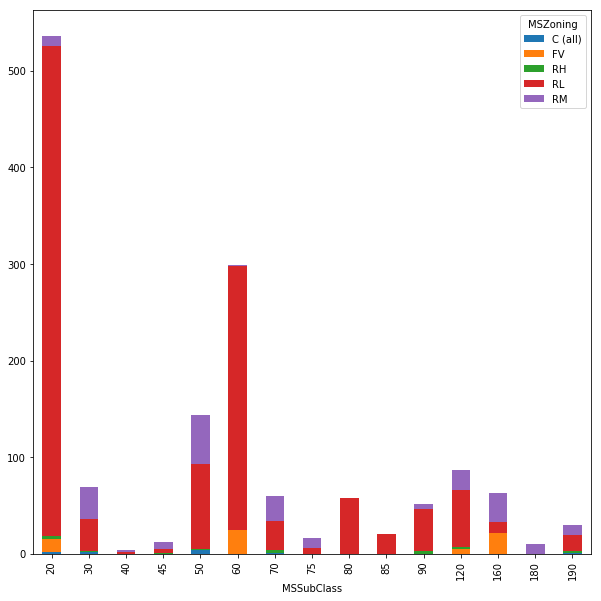

In [11]:
# the two attributes 'MSSubClass' and 'MSZoning' are a litttle bit unknown to me
# lets have a look at their distribution
my_table = pd.crosstab(index = explore['MSSubClass'],
 columns = explore['MSZoning'])
print type(my_table)
my_table.plot.bar(stacked = True)

for the last figures, lets focuse on the most important numerical features

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b800990>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10d063d10>]], dtype=object)

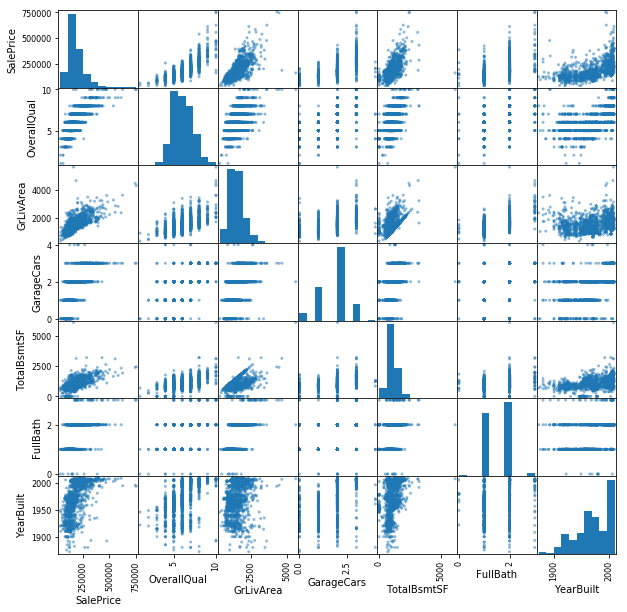

In [12]:
linear_attributes = ["SalePrice","OverallQual", "GrLivArea",
"GarageCars","TotalBsmtSF","FullBath","YearBuilt"]

scatter_matrix(explore[linear_attributes])

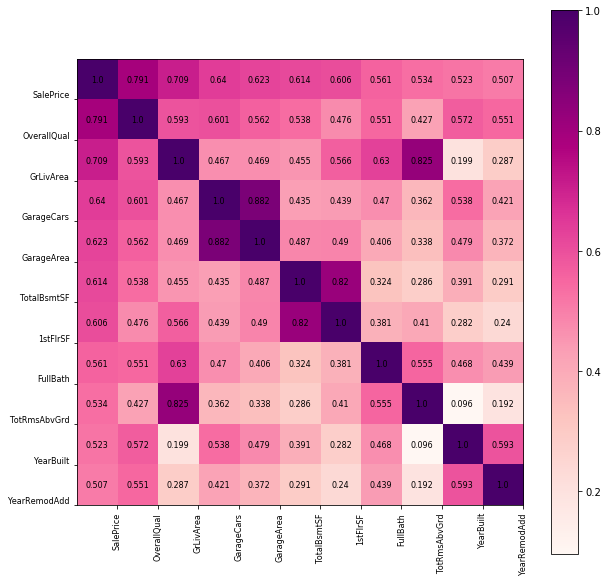

In [13]:
def partial_corrolation_plot(data, target = 'SalePrice', k = 10):
    ''' plot corrolation between most corrolated numerical attributes'''
    corr_matrix = data.corr()
    # get the most linear corrolated attributes
    important_features = \
    corr_matrix[target].abs().sort_values(ascending = False).index.values[:(k +1)]
    # calculate the corrolation for this subset
    corr_matrix = data[important_features].corr()
    fig, ax = plt.subplots()
    cax = ax.imshow(corr_matrix.values, interpolation= 'nearest', cmap = 'RdPu')
    ax.set_yticks(np.arange(len(list(corr_matrix)))+.5)
    ax.set_xticks(np.arange(len(list(corr_matrix)))+.5)
    ax.set_yticklabels(list(corr_matrix), rotation=0,fontsize=8,
    verticalalignment = 'bottom' )
    ax.set_xticklabels(list(corr_matrix), rotation=90,fontsize=8)
    fig.colorbar(cax)
    # write the value of corrolation on the plot
    for (j,i),label in np.ndenumerate(corr_matrix):
        ax.text(i,j,round(label,3),ha='center',va='center', fontsize =8)
partial_corrolation_plot(explore, target = 'SalePrice', k = 10)

# preprocessing

in this section I will do:
* handle missing data
* outliers
* transform categorical features to numerical
* define new features( transform existing features and aggregate them)
* scale features

In [14]:
# seperate X nad y
y_train = data['SalePrice']
X_train = data.drop(['Id','SalePrice'], axis = 1)
X_test = data_test.drop(['Id'], axis =1)


some of categorical features have order and can be easily be converted to numerrical. for example, for GarageQual that ranges from Excellant to Poor, we can give 5 to 1, and in this way we do not need to use one hot encoding, which means less number of features, of cource this approch is not appliable for all features. in contrast, MSSubClass and Mosold are noe numerical but they are inherently categorical.

In [15]:

def modify_type(X):
    ''' some features are originally categorical but represented as numerical
    while there are some categorical feats that can be represented as numerical
    '''

    X = X.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40",
    45 : "SC45", 50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75",  80 : "SC80",
    85 : "SC85", 90 : "SC90", 120 : "SC120", 150 : "SC150", 160 : "SC160",
    180 : "SC180", 190 : "SC190"},
    "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
    7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"},
    "ExterQual" : {"Ex": 5, "Gd": 4, "TA": 3, "Fa" : 2, "Po":1},
    "ExterCond" : {"Ex": 5, "Gd": 4, "TA": 3, "Fa" : 2, "Po":1},
    "BsmtQual" : {"Ex": 5, "Gd": 4, "TA": 3, "Fa" : 2, "Po":1},
    "BsmtCond" : {"Ex": 5, "Gd": 4, "TA": 3, "Fa" : 2, "Po":1},
    "BsmtExposure" : {"Gd": 4, "Av": 3, "Mn": 2, "No" : 1},
    "BsmtFinType1" : {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec" : 3, "LwQ":2,"Unf":1},
    "BsmtFinType2" : {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec" : 3, "LwQ":2,"Unf":1},
    "HeatingQC" : {"Ex": 5, "Gd": 4, "TA": 3, "Fa" : 2, "Po":1},
    "KitchenQual" : {"Ex": 5, "Gd": 4, "TA": 3, "Fa" : 2, "Po":1},
    "FireplaceQu" : {"Ex": 5, "Gd": 4, "TA": 3, "Fa" : 2, "Po":1},
    "GarageQual" : {"Ex": 5, "Gd": 4, "TA": 3, "Fa" : 2, "Po":1},
    "GarageCond" : {"Ex": 5, "Gd": 4, "TA": 3, "Fa" : 2, "Po":1},
    "PoolQC" : {"Ex": 5, "Gd": 4, "TA": 3, "Fa" : 2, "Po":1},
    "GarageFinish" : {"Fin": 3, "RFn": 2, "Unf": 1},
    })
    return X
X_train = modify_type(X_train)
X_test = modify_type(X_test)

### outlier
in the description of the data it is suggested to eliminate data points with ground level area greater than 4000


In [16]:
# delet outliers
select_indice = (X_train['GrLivArea'] < 4500)
X_train = X_train[select_indice]
y_train = y_train[select_indice]

## seperating categorical and numerical features

for this purpose: <br>
* first, write a function to give the list of categorical and numerical features based on their type
* second, a class that gets a list of features and return data just with given features

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
def cat_num_list(X):
    ''' seperate numerical and categorical features based on their type'''
    cat = []
    num = []
    for col in  list(X.columns):
        if (X[col].dtype) != ('object'):
            num.append(col)
        else :
            cat.append(col)
    return num, cat

class DataFrameSelector(BaseEstimator, TransformerMixin):
    ''' choose subset of data(seperate categorical and numerical features) and\
    convert to numpy array'''
    def __init__(self, attr_list):
        self.attr_list = attr_list

    def fit(self, X,y = None):
        if self.attr_list is None:
            raise ValueError('attribue list is empty')
        return self

    def transform(self, X, y = None):
        return X[self.attr_list]

In [18]:
# use the written function to get a list of numerical and categorical features
num_features, cat_features =  cat_num_list(X_train)
print " number of numerical fetures", len(num_features)
print num_features
print " number of categoricl fetures", len(cat_features)
print cat_features


 number of numerical fetures 48
['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'YrSold']
 number of categoricl fetures 31
['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation'

###  mising data

So, here is the process for handling missing data
There are some features that missing value in them accually means that they do not have that attributes. like None in "PoolQual" means the house doen not have a Pool, I call them type 1
* First I am going to seperate categorical features and numberical features.
* then for missing features type 1, if it is a categorical, replace with new category, like "DontHave" and if that is a numerical feature replace with 0.
* next step is imputing for **real missing data**, although sklearn have imputer class as a preprocss step, I am up to code my own imputer seperately for categorical and numerical data. the reason is that I prefer to keep the data type as data frasme

before starting this section, lets write some functions and classes that I will use later in this section

In [19]:
class fill_missing_1(BaseEstimator, TransformerMixin):
    ''' for some categorival attributes None  means it does not have the feature
    this class fill None with DONT '''
    def __init__(self, attr_list = None, fill_by = 0):
        self.attr_list = attr_list
        self.fill_by = fill_by
    def fit(self, X, y = None):
        return self
    def transform(self, X, Y = None):
        if self.attr_list is not None:
            X[self.attr_list] = X[self.attr_list].fillna(self.fill_by)
            return X
        else:
            return X
#
class my_Imputer_cat(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        l = {}
        for col in list(X.columns):
            l[col] = (X[col].value_counts().index[0])
        self.fillingvalue = pd.Series(l)
        return self

    def transform(self, X, y = None):
        return X.fillna(self.fillingvalue)

class my_Imputer_num(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        self.fillingvalue = X.mean()
        return self
    def transform(self, X, y = None):
        return X.fillna(self.fillingvalue)

In [20]:
# lets look at features with missing values
print X_train.isnull().sum(axis = 0).sort_values(ascending = False)

PoolQC           1452
MiscFeature      1404
Alley            1367
Fence            1177
FireplaceQu       690
LotFrontage       259
GarageCond         81
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageQual         81
BsmtExposure       38
BsmtFinType2       38
BsmtFinType1       37
BsmtCond           37
BsmtQual           37
MasVnrArea          8
MasVnrType          8
Electrical          1
LotConfig           0
LandSlope           0
MSZoning            0
Foundation          0
ExterCond           0
ExterQual           0
Exterior2nd         0
Exterior1st         0
RoofMatl            0
RoofStyle           0
YearRemodAdd        0
                 ... 
MoSold              0
MiscVal             0
PoolArea            0
ScreenPorch         0
3SsnPorch           0
EnclosedPorch       0
OpenPorchSF         0
WoodDeckSF          0
PavedDrive          0
GarageArea          0
GarageCars          0
Fireplaces          0
Functional          0
KitchenQual         0
BsmtUnfSF 

after checking  data description, for all attributes with missing value except LotFrontage and Electrical , None is more likely that they do not have that feature and in the below cell the list of them exist in att_missing_1

In [21]:
attr_missing = list(data.isnull().sum(axis = 0).sort_values(ascending = False)\
.index.values)[:19]
att_missing_1 = [attr for attr in attr_missing if attr  not in \
('LotFrontage', 'Electrical')]


In [22]:
from sets import Set
# missing value that None means 0(numerical) is the intersection between numerical features and att_missing_1
att_none_to_0 = [x for x in  Set(att_missing_1).intersection(Set(num_features))]
# meanssing value that None means NO(categirical ) is the intersection between categorical features and att_missing_1
att_none_to_no = [x for x in  Set(att_missing_1).intersection(Set(cat_features))]

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: the sets module is deprecated
  """Entry point for launching an IPython kernel.


now it is enough that custom written class **fill_missing_1** recieves att_none_to_0 and att_none_to_no and following that imputer apply

## one hot encoding for catecorical featues

to feed data to estimators, the data shold be numerical and since the remaining categorical features do not have order( for examples neighbourhoods do not have order), one hot encoding is used via get_dummes method of data frame

In [23]:
class my_OnehotEncoding(BaseEstimator, TransformerMixin):
    ''' one hot encoding to change categorical data to numerical'''
    def fit(self, X_cat, y = None):
        self.columns_list_ = list(pd.get_dummies(X_cat).columns)
        return self
    def transform(self, X_cat, y = None):
        x_1hot_init = pd.get_dummies(X_cat)
        if list(x_1hot_init.columns) == self.columns_list_:
            X_cat_1hot = x_1hot_init
        else:
            exta_columns = Set(self.columns_list_) - Set(list(x_1hot_init.columns))
            for c in exta_columns:
                x_1hot_init[c] = 0
            X_cat_1hot = x_1hot_init[self.columns_list_]
        return X_cat_1hot


## other transformers in the preprocess pipline

before data is transformed to numpy array, lets get list of features, they may be needed in the feature

In [24]:

class feature_list(BaseEstimator, TransformerMixin):
    ''' get the list of features for maybe later use'''
    def fit(self, X, y = None):
        self.attributes_ = X.columns
        return self
    def transform(self, X, y= None):
        return X

In [25]:
# a class to change data type from dataframe to numpy
class to_numpy(BaseEstimator, TransformerMixin):
    def fit(self, X , y = None):
        return self
    def transform(self, X, y = None):
        return X.values

In [34]:
# aggregate new features to define new ones
class add_new_features(BaseEstimator, TransformerMixin):

    ''' function to aggregate existing features and transform some of them'''

    def fit(self, data, y = None):
        return self

    def transform(self, data, y = None):
        data['square_quall'] = data['OverallQual']** 2
        data['square_year'] = (data['YrSold'] - data['YearBuilt'])** 2
        data['square_reno'] = (data['YrSold'] - data['YearRemodAdd'])** 2
        data['YrSold'] = 2010 - data['YrSold']
        data['sqrt_living'] = np.sqrt(data['GrLivArea'])
        data['log_sqft'] = np.log1p(data['GrLivArea'])
        data['squrt_lot'] = np.sqrt(data['LotArea'])
        data['whole_bath'] = data['FullBath']+ data['HalfBath']
        data['garage_t'] = data['GarageCars']*data['GarageQual']
        data['garage_tt'] = data['GarageQual']*data['GarageArea']
        data['base_t'] = data['BsmtQual']* data['TotalBsmtSF']
        data['overal_status'] = data['OverallCond']*data['OverallQual']
        data['y2'] = (data['YrSold'] - data['YearRemodAdd'])**3
        data["AllPorchSF"] = data["OpenPorchSF"] + data["EnclosedPorch"] + \
        data["3SsnPorch"] + data["ScreenPorch"]
        data['ext'] = data['ExterCond']*data['ExterQual']
        data['Kitchen'] = data['KitchenAbvGr'] * data['KitchenQual']
        return data

# whole preprocessing pipeline


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([\
('num_selector',DataFrameSelector(num_features)),\
('missing1', fill_missing_1(attr_list = att_none_to_0, fill_by = 0)),

('imputer', my_Imputer_num()),
('add', add_new_features()),
('get_num_featutes', feature_list()),
#
#('skew', skew_data()),
('to_numpy',to_numpy()),
('scale', StandardScaler()),
])

#
cat_pipeline = Pipeline([\
('cat_selector', DataFrameSelector(cat_features)),
('missing1', fill_missing_1(attr_list = att_none_to_no, fill_by = "NOO")),
('imputer', my_Imputer_cat()),
('encode', my_OnehotEncoding()),
('get_cat_features', feature_list()),
('to_numpy',to_numpy()),
])
#
# # #
full_pipeline = FeatureUnion(transformer_list = [\
('num_pipeline', num_pipeline),
('cat_pipeline', cat_pipeline),\
])
#

In [38]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

num_attributes = full_pipeline.transformer_list[0][1].steps[4][1].attributes_
cat_attributes = full_pipeline.transformer_list[1][1].steps[4][1].attributes_
total_attributes = list(num_attributes) + list(cat_attributes)

print len(total_attributes)

y = y_train.values.reshape(-1,1)
y_log = np.log1p(y)

283


# select and train a model

since it seems that only some subset of features is usefull, it is a good idea to use Lasso to get ride of unneccessary features

## LASSO

In [48]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
   
lasso = Lasso(random_state = 42)
param_grid = {'alpha' : [.0003,.0005,.0007,.0009]}
grid = GridSearchCV(estimator = lasso, param_grid = param_grid,
scoring = 'neg_mean_squared_error', cv = 5, refit = True)
grid.fit(X_train_prepared , y_log)
for score, param in zip(grid.cv_results_['mean_test_score'],grid.cv_results_['params']):
    print (np.sqrt(-score), param)
print grid.best_params_

(0.11029593635825222, {'alpha': 0.0003})
(0.1095306439955831, {'alpha': 0.0005})
(0.10973456122608054, {'alpha': 0.0007})
(0.11037207141244433, {'alpha': 0.0009})
{'alpha': 0.0005}


score:  0.109530643996


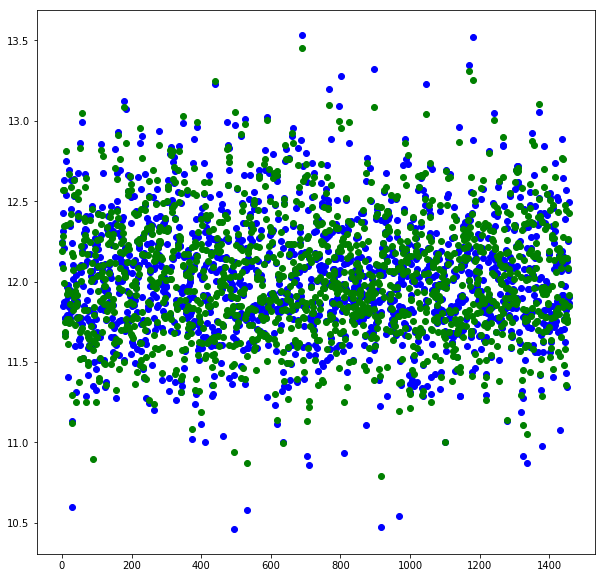

In [53]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
lasso = Lasso(random_state = 42, alpha = .0005)
prediction = cross_val_predict(lasso, X_train_prepared, y=y_log,
 cv=5)
print "score: ", np.sqrt(mean_squared_error(y_log, prediction))
plt.figure()
plt.plot(np.arange(len(y_log)), y_log, 'bo')

plt.plot(np.arange(len(y_log)), prediction, 'go')